In [174]:
import whisper
import os
import pandas as pd
import torch
from xml.etree import ElementTree as ET
import nltk
import warnings
import numpy as np
import re
import pytz
from datetime import datetime,timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import yfinance as yf
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coooo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [180]:
from configparser import ConfigParser
from pathlib import Path
BASE_DIR =Path.cwd().parent
print(BASE_DIR)
CONFIG = ConfigParser()
CONFIG.read(BASE_DIR / "config.ini")
POLYGON_KEY = CONFIG.get("UPSTREAM", "polygon_api_key")


e:\BNY Mellon capstone project\BKG


In [7]:


# 加载模型
model = whisper.load_model("base")

# 进行语音识别
result = model.transcribe("State Street Corporation (NYSE_STT) Apr-12-2024 - Audio.mp3")

# # 打印结果
# for segment in result["segments"]:
#     print(f"Start: {segment['start']}s, End: {segment['end']}s, Text: {segment['text']}")


[*********************100%%**********************]  1 of 1 completed

None


In [8]:
import json
with open('STT-Q1-2024-S2T.json', 'w') as f:
    json.dump(result, f)

In [9]:
with open('data.txt', 'w') as file:
    json.dump(result["text"], file)

In [14]:
print(result["text"][-100:])

vailable in the appendix to our slide presentation, also available in the IR section of our website.


In [32]:
for segment in result["segments"]:
    print(f"Start: {segment['start']}s, End: {segment['end']}s, Text: {segment['text']}")

Start: 0.0s, End: 7.88s, Text:  Good morning and welcome to State Street Corporations, first quarter 2024 earnings conference
Start: 7.88s, End: 9.88s, Text:  call and webcast.
Start: 9.88s, End: 21.32s, Text:  Today's discussion is being broadcast live on State Street's web sites at investors.state.com.
Start: 21.32s, End: 24.84s, Text:  This conference call is also being recorded for replay.
Start: 24.84s, End: 30.08s, Text:  State Street's conference call is copyrighted and all rights are reserved.
Start: 30.08s, End: 38.84s, Text:  This call may not be recorded or re-broadcast or distribution in whole or in part without
Start: 38.84s, End: 43.4s, Text:  the expressed written authorization from State Street Corporation.
Start: 43.4s, End: 49.120000000000005s, Text:  The only authorized broadcast of this call will be housed on the State Street website.
Start: 49.12s, End: 54.72s, Text:  Now I would like to introduce Irene Chizelle-Biller, global head of investor relations at State
St

In [5]:
import difflib

def find_best_match(original_text, transcribed_segments):
    matcher = difflib.SequenceMatcher(None, original_text, transcribed_segments)
    match = matcher.find_longest_match(0, len(original_text), 0, len(transcribed_segments))
    return original_text[match.a: match.a + match.size]


original_text = "Good morning, and welcome to State Street Corporation's First Quarter 2024 Earnings Conference Call and Webcast. Today's discussion is being broadcasted live on State Street's website at investors.statestreet.com. This conference call is also being recorded for replay. State Street's conference call is copyrighted, and all rights are reserved. This call may not be recorded or rebroadcast or distribution in whole or in part without the expressed written authorization from State Street Corporation. The only authorized broadcast of this call will be housed on the State Street website. Now I would like to introduce Ilene Fiszel Bieler, Global Head of Investor Relations at State Street. Please go ahead."
transcribed_segments = " Good morning and welcome to State Street Corporations, first quarter 2024 earnings conference"

best_match = find_best_match(original_text, transcribed_segments)
print("Best match found:", best_match)

Best match found:  and welcome to State Street Corporation


In [147]:
def parse_time(time_str):
    
    return datetime.strptime(time_str, '%A, %B %d, %Y %I:%M %p %Z')

def timeAndTicker(root):
    time_element = root.find(".//header/time")
    if time_element is not None:
        time_element = parse_time(time_element.text)
    ticker =  root.find(".//header/ticker").text
    return time_element, ticker




In [137]:
def preprocess_text(text):
    """简单的文本预处理，移除非字母字符并转换为小写。"""
    import re
    return re.sub(r'\W+', ' ', text.lower()).strip()

def calculate_similarity(text1, text2):
    """计算两段文本的余弦相似度。"""
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
def split_text_into_sentences(text):

    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    return tokenizer.tokenize(text)
def find_most_similar_sentence(sentence, segments):
    vectorizer = TfidfVectorizer()

    max_similarity = 0
    best_segment = None
    best_index = -1
    target_length = len(preprocess_text(sentence))

    # 构建所有可能的连续 segment 的组合的文本
    for start_index in range(len(segments)):
        combined_text = ""
        for end_index in range(start_index, len(segments)):
            combined_text += " " + segments[end_index]['text']
            combined_length = len(preprocess_text(combined_text))

            # 只有当组合文本长度不超过目标句子长度过多时才计算相似度
            if combined_length < target_length * 1.5:  # 允许一定的长度超出
                processed_combined_text = preprocess_text(combined_text)
                all_texts = [preprocess_text(sentence), processed_combined_text]
                tfidf_matrix = vectorizer.fit_transform(all_texts)
                similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

                # 更新最大相似度和最佳段落
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_segment = segments[end_index]
                    best_index = end_index
            else:
                break  # 终止内部循环如果组合长度超过了目标句子长度的1.5倍

    return best_segment, max_similarity, best_index
def get_last_two_sentences(text):

    sentences = split_text_into_sentences(text)
    # Combine the last two sentences, handle texts with less than two sentences.
    last_two_sentences = " ".join(sentences[-2:]) if len(sentences) >= 2 else " ".join(sentences)
    return last_two_sentences

In [247]:
def convert_gmt_to_et(gmt_time):
    """将 GMT 时间转换为 ET 时间。"""
    if gmt_time.tzinfo is None or gmt_time.tzinfo.utcoffset(gmt_time) is None:
        gmt_timezone = pytz.timezone('GMT')
        gmt_time = gmt_timezone.localize(gmt_time)  # 给 naive datetime 设置 GMT 时区

    et_timezone = pytz.timezone('America/New_York')
    et_time = gmt_time.astimezone(et_timezone)  # 转换到 ET 时区
    print(f"et_time: {et_time}")  # 打印以确认转换正确
    return et_time

def load_daily_stock_data(ticker, date):
    """
    加载指定日期的每分钟股票数据。
    
    Args:
        ticker (str): 股票代码，例如 'AAPL'。
        date (str): 日期字符串，格式为 'YYYY-MM-DD'。
    
    Returns:
        DataFrame: 包含股票数据的 DataFrame。
    """
    start_date = date
    end_date = pd.to_datetime(date).date() + pd.Timedelta(days=1)
    data = yf.download(ticker, start=start_date, end=end_date, interval='1m')
    return data
def get_specific_data(specific_time, stock_data):
    specific_time = pd.to_datetime(specific_time)  # 确保这是 datetime 对象
    specific_data = None
    if specific_time in stock_data.index:
        specific_data = stock_data.loc[specific_time]
        print(specific_data)
    else:
        print("No data available for the specified time.")
    return specific_data

In [248]:
global_time = []
global_price = []

In [249]:
def add_presentation_stockprice_to_xml(root, time, stock_data, result):
    """
    Add summaries to the XML file based on the section presentation.
    
    Args:
        root: ElementTree of the transcript
    """
    
    print("processing presentation section")
    # Assume result is accessible and contains the whisper_segments
    whisper_segments = result["segments"]

    for statement_element in root.findall(".//statement"):
        speaker_element = statement_element.find("speaker")
        text_element = speaker_element.find("text")
        text = text_element.text.strip()

        last_sentence = get_last_two_sentences(text)

        best_segment, best_similarity, best_index = find_most_similar_sentence(last_sentence, whisper_segments)

        # Print the best matching segment's text, similarity score, and times
        # print("Target sentence: ", last_sentence)
        # print("Best Matching Segment:", best_segment['text'])
        # print("Similarity Score:", best_similarity)
        # print(f"Start Time: {best_segment['start']}s, End Time: {best_segment['end']}s")
        
        
        end_time_gmt = time + timedelta(seconds=best_segment['end'])
        end_time = convert_gmt_to_et(end_time_gmt)
        stock_price = get_specific_data(end_time, stock_data)
        # print(f"Global time: {end_time_gmt}")
        # print(f"stock_data: ", stock_data)
        # print(stock_data)
        # print("----------------------------------------------------")
        timestamp_element = ET.SubElement(text_element, "timeStamp")
        timestamp_element.text = end_time_gmt
        stock_element = ET.SubElement(text_element, "stock_price")
        stock_element.text = stock_price["close"]
        global_time.append(end_time)
        global_price.append(stock_price)
        
        # if "[" in text:
        #     print("\nTrigger\n")
        #     ending_text = text.split(']')[-1]
        #     sentence = split_text_into_sentences(ending_text)[0]
        #     # print(f"ending text: {sentence}")
        #     best_segment, best_similarity,max_index = find_most_similar_sentence(sentence, whisper_segments[i:])
        #     # print("Best Matching Segment:", best_segment['text'])
        #     # print("Similarity Score:", best_similarity)
        #     # print(whisper_segments[max_index]["text"], whisper_segments[i+max_index]["text"])
        #     i = i+max_index
        #     start_index = i
        #     processed_paragraph = preprocess_text(ending_text)

        # while i < len(whisper_segments):
        #     current_text += " " + whisper_segments[i]['text']
        #     new_processed_text = preprocess_text(current_text)
        #     similarity = calculate_similarity(processed_paragraph, new_processed_text)
        #     print(similarity)
        #     if similarity > max_similarity:
        #         max_similarity = similarity
        #         best_match_text = current_text
        #         i += 1
                
        #     elif similarity > 0.7 and similarity < max_similarity and abs(len(current_text) - len(processed_paragraph))< 30:
        #         start_index = i
        #         break
        #     else:
        #         i +=1
        # print(f"origin Text: {processed_paragraph}")
        # print(f"Matched Text: {best_match_text}")
        # print(f"Start Time: {whisper_segments[start_index]['start']}s, End Time: {whisper_segments[i]['end']}s")    
        # print("----------------------------------------------------")

        # # Use summarizer to get the summary for the text
        # summary = self.summarizer.summarize(text, "statement")
        # # Create and append the summary tag
        # summary_element = ET.SubElement(text_element, "summary")
        # summary_element.text = summary
    return root


In [250]:
def add_QA_stockprice_to_xml(root, time, stock_data, result):
        """
        Add summaries to the XML file based on the section Question and Answer.
        
        Args:
            root: ElementTree of the transcript
        """
        print("processing QA section")
        whisper_segments = result["segments"]
        # Find the <section name="Question and Answer"> section
        qa_section = root.find("./body/section[@name='Question and Answer']")

        # Iterate over the elements within the section 
        
        for element in qa_section.iter():
            text_type = ""

            if element.tag == "transition" or element.tag=="ending":
                text_type = "transition"
                
            elif "question" in element.tag.lower():
                text_type = "statement"
                
            elif "answer" in element.tag.lower():
                text_type = "statement"
                

            if element.tag == 'text':
                if text_type == "answer":
                    text = ""
                    if element.text is None:
                        print("There is None text in Q&A")
                        print("_________________________________________")
                    else:
                        text = element.text.strip()
                    

                    last_sentence = get_last_two_sentences(text)

                    best_segment, best_similarity, best_index = find_most_similar_sentence(last_sentence, whisper_segments)

                    
                    
                    end_time_gmt = time + timedelta(seconds=best_segment['end'])
                    end_time = convert_gmt_to_et(end_time_gmt)
                    stock_price = get_specific_data(end_time, stock_data)
                    # print(f"Global time: {end_time_gmt}")
                    # print(f"stock_data: ", stock_data)
                    # print(stock_data)
                    # print("----------------------------------------------------")
                    timestamp_element = ET.SubElement(element, "timeStamp")
                    timestamp_element.text = end_time_gmt
                    stock_element = ET.SubElement(element, "stock_price")
                    stock_element.text = stock_price["close"]
                    global_time.append(end_time)
                    global_price.append(stock_price)

        return root

In [251]:
print(convert_gmt_to_et(time))
stock_data = load_daily_stock_data(ticker,convert_gmt_to_et(time))

[*********************100%%**********************]  1 of 1 completed

2024-04-12 10:00:00-04:00
2024-04-12 10:00:00-04:00
2024-04-12 10:00:00-04:00


In [252]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-04-12 10:00:00-04:00,73.529999,73.669998,73.449997,73.635002,73.635002,0
2024-04-12 10:01:00-04:00,73.669998,73.790001,73.489998,73.514999,73.514999,13805
2024-04-12 10:02:00-04:00,73.510002,73.529999,73.330002,73.510002,73.510002,18381
2024-04-12 10:03:00-04:00,73.480003,73.519997,73.230003,73.370003,73.370003,20214
2024-04-12 10:04:00-04:00,73.379997,73.610001,73.370003,73.540001,73.540001,9790
...,...,...,...,...,...,...
2024-04-12 15:55:00-04:00,75.407501,75.580002,75.407501,75.474998,75.474998,47422
2024-04-12 15:56:00-04:00,75.470001,75.510002,75.430000,75.459999,75.459999,84319
2024-04-12 15:57:00-04:00,75.464996,75.589996,75.459999,75.580002,75.580002,64975


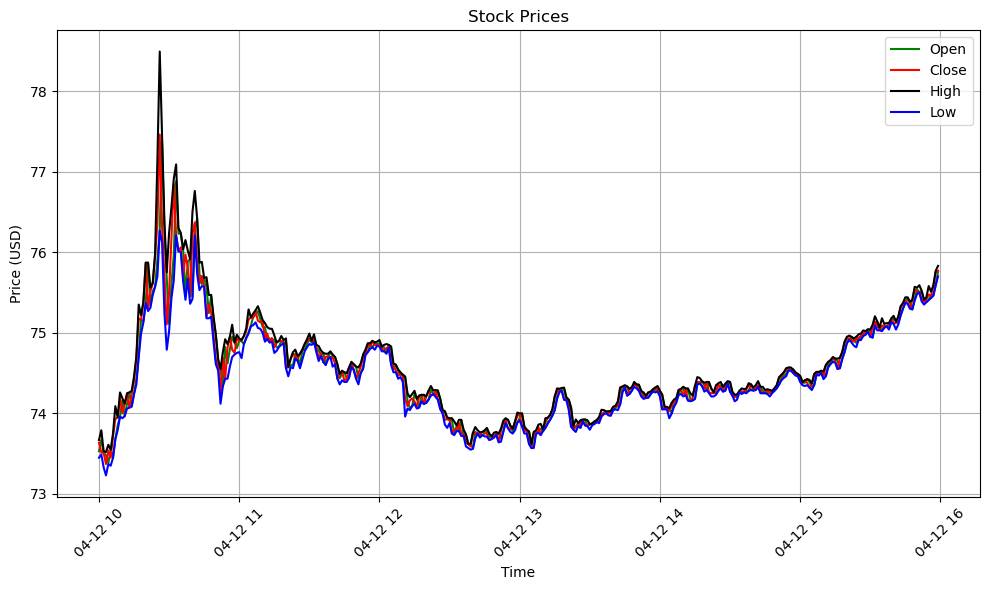

In [253]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stock_data(stock_data):
    """
    Plots the stock data for open, close, high, and low prices.

    Args:
        stock_data (DataFrame): DataFrame containing the stock data with datetime index.
    """
    # Check if data is empty
    if stock_data.empty:
        print("No data available to plot.")
        return

    # Ensure the index is a datetime index
    stock_data.index = pd.to_datetime(stock_data.index)

    plt.figure(figsize=(10, 6))
    plt.plot(stock_data.index, stock_data['Open'], label='Open', color='green')
    plt.plot(stock_data.index, stock_data['Close'], label='Close', color='red')
    plt.plot(stock_data.index, stock_data['High'], label='High', color='black')
    plt.plot(stock_data.index, stock_data['Low'], label='Low', color='blue')

    plt.title('Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better visibility
    plt.tight_layout()  # Adjust subplots to give some padding

    plt.show()

# Example usage
# Assuming 'stock_data' is your DataFrame loaded with stock prices
plot_stock_data(stock_data)

In [254]:
tree = ET.parse("STT-Q1-2024.xml")
root = tree.getroot()
time, ticker = timeAndTicker(root)
print(time, ticker)
root = add_presentation_stockprice_to_xml(root,time,stock_data, result)
root = add_QA_stockprice_to_xml(root, time, stock_data, result)
tree.write("STT-Q1-2024_timestamp.xml", encoding='utf-8', xml_declaration=True)
print(f"Processed STT-Q1-2024_timestamp.xml")

2024-04-12 14:00:00 STT
processing presentation section
2024-04-12 10:00:56.720000-04:00
No data available for the specified time.


TypeError: 'NoneType' object is not subscriptable